# Lagrange Propagation
One of the most efficient ways to perform the numerical propagation of some Cartesian state assuming a Keplerian motion, is the use of the Lagrange coefficients. These are four scalar coefficients $F,G,F_t,G_t$ defined by the relation:

$$
\begin{array}{l}
\mathbf r = F\mathbf r_0 + G\mathbf v_0 \\
\mathbf v = F_t\mathbf r_0 + Gt\mathbf v_0
\end{array}
$$

Analytical expressions for these coefficients are available in terms of the True Anomaly difference, the Eccentric Anomaly difference, as well as the Hyperbolic Anomaly difference or the Universal Anomaly difference between the state $\mathbf r_0, \mathbf v_0$ and the state $\mathbf r, \mathbf v$.

The details on these analytical expressions and their derivation can be found, for example, in the seminal book by Richard Battin: "Fundamentals of Astrodynamics." {cite:p}`battin`.

In `pykep` the {func}`pykep.propagate_lagrangian` {func}`pykep.propagate_lagrangian_v` implement the keplerian propagation algorithm based on the Lagrange coefficients, as well as the analytical computation of the resulting State Transition Matrix.

:::{note}
`pykep` will fail for the perfectly parabolic case. For example $\mu=1$, $\mathbf r = [1,0,0]$ and $\mathbf v = [0,0,1]$

In this notebook we show a few simple use cases for this function.

In [1]:
import pykep as pk
import numpy as np
import time

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

We start profiling a bit the speed of our CPUs .....

In [2]:
t1 = time.perf_counter()
for i in range(100000):
    res = pk.propagate_lagrangian([[1,0,0], [0,1,0]], 1, 1, False)
t2 = time.perf_counter()
print(f"Only Keplerian Propagations")
spicep = t2 - t1
print(f" Real time: {spicep:.5f} seconds")

Only Keplerian Propagations
 Real time: 0.09781 seconds


In [3]:
t1 = time.perf_counter()
for i in range(100000):
    res = pk.propagate_lagrangian([[1,0,0], [0,1,0]], 1, 1, True)
t2 = time.perf_counter()
print(f"Keplerian Propagations with the STM computations")
spicep = t2 - t1
print(f" Real time: {spicep:.5f} seconds")

Keplerian Propagations with the STM computations
 Real time: 0.19343 seconds


Let us consider non-dimensional units $\mu=1$. The following code computes the positions along one period of circulr orbits, it makes use of the vectorized version {func}`pykep.propagate_lagrangian_v` which is not necessarily faster but surely convenient in this case.

In [13]:
t_grid = np.linspace(0, 2 * np.pi, 100)
r0 = [1,0,0]
v0 = [0,1,0]
orbit1 = pk.propagate_lagrangian_grid(rv = [r0,v0], tofs = t_grid, mu=1., stm = False)
r0 = [0,1,0]
v0 = [0,0,1]
orbit2 = pk.propagate_lagrangian_grid(rv = [r0,v0], tofs = t_grid, mu=1., stm = False)
r0 = [1,0,0]
v0 = [0,0,1]
orbit3 = pk.propagate_lagrangian_grid(rv = [r0,v0], tofs = t_grid, mu=1., stm = False)
pos1 = np.array([it[0] for it in orbit1])
pos2 = np.array([it[0] for it in orbit2])
pos3 = np.array([it[0] for it in orbit3])


Let us plot the resulting orbits. `pykep` has a dedicated module for this, but just for the purpose of this tutorial lets spell this out:

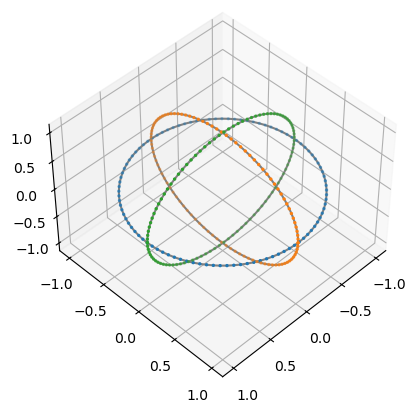

In [14]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(pos1[:,0], pos1[:,1], pos1[:,2], 'gray')
ax.plot3D(pos2[:,0], pos2[:,1], pos2[:,2], 'gray')
ax.plot3D(pos3[:,0], pos3[:,1], pos3[:,2], 'gray')

ax.scatter3D(pos1[:,0], pos1[:,1], pos1[:,2], s=2);
ax.scatter3D(pos2[:,0], pos2[:,1], pos2[:,2], s=2);
ax.scatter3D(pos3[:,0], pos3[:,1], pos3[:,2], s=2);

ax.view_init(45,45)

Ok, this is admittedly underwhelming and very basic ....... lets try to do something a bit more advanced.

## Computing the overall STM for multi-impulsive legs

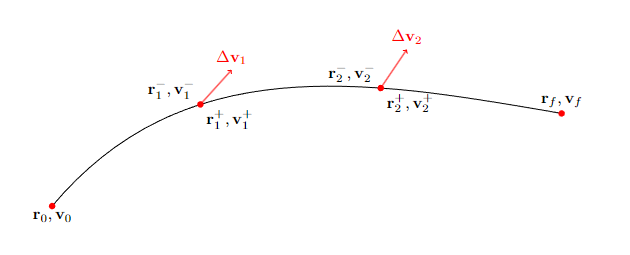

In [15]:
from IPython.display import Image
Image(filename="./sf_diagram.png")

With reference to the diagram above (a common block present, for example, in the Sims-Flanagan {cite:p}`sims` model for low-thrust orbital transfers), we consider a three segment leg and we assume the ballistic arc to have length $\frac{dt}{2}, dt$ and $\frac{dt}{2}$ 
we now use {func}`pykep.propagate_lagrangian` to compute the gradient of the final state [$\mathbf r_f, \mathbf v_f$] with respect to the initial state [$\mathbf x_f = \mathbf r_0, \mathbf v_0$] as well as of the applied $\Delta \mathbf v_i$.  That is, as we shall see, all information stored in the STMs of this bi-impulsive transfer. 

This is actually rather straightforward after we get convinced that, indicating with $\mathbf M_{i}$ the state transition matrix between the states [$\mathbf r_{i-1}^+, \mathbf v_{i-1}^+$] and [$\mathbf r_{i}^-, \mathbf v_{i}^-$], then the first order variations of the final state w.r.t. variations of the state at the nodes are:

$$
\begin{array}{r}
\mathbf M_{3}\mathbf M_{2} \mathbf M_{1} \delta \mathbf x_0 \\
\mathbf M_{3}\mathbf M_{2} \delta \mathbf x_1 \\
\mathbf M_{3} \delta \mathbf x_2
\end{array}
$$

trivially, this allows to compute easily the seeked gradients.

For example $\frac{\partial \mathbf x_f}{{\partial \Delta \mathbf v_1}}$ will be $\mathbf M_{3}\mathbf M_{2} \mathbf I_v$.

where we have introduced the matrix $\mathbf I_v$ that selects the velocity components of the STM.

$$
\mathbf Iv = \left[\begin{array}{llllll}
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&0&1&0&0\\
0&0&0&0&1&0\\
0&0&0&0&0&1\\
\end{array}\right]
$$

We have thus also shown how the complexity of computing the gradients is linear with the number of impulses in a trajectory leg since $N$ impulses would result into the computation of $N$ state transition matrices and $N$ matrix multiplications. Lets see one specific exampl below:

In [16]:
# The case considered is defined bythe following starting conditions
r0 = [1,0,0]
v0 = [0,1,0]
Dv1 = [0.1,-0.1,0.1]
Dv2 = [0.2,0.2, -0.2]
dt = 0.3

# We compute the matrices M
rv1, M1 = pk.propagate_lagrangian(rv = [r0, v0], tof = dt/2, mu=1., stm=True)
# We add the first impulse
r1 = rv1[0]
v1 = [a+b for a,b in zip(rv1[1], Dv1)]
rv2, M2 = pk.propagate_lagrangian(rv = [r1, v1], tof = dt, mu=1., stm=True)
# We add the second impulse
r2 = rv2[0]
v2 = [a+b for a,b in zip(rv2[1], Dv2)]
rv3, M3 = pk.propagate_lagrangian(rv = [r2, v2], tof = dt/2, mu=1., stm=True)

... and we are now ready to compute all the necessary gradients. Lets start with:

$$
\frac{\partial \mathbf x_f}{\partial \mathbf x_0} = \mathbf M_{3}\mathbf M_{2} \mathbf M_{1}
$$

In [17]:
print(M3@M2@M1)

[[ 1.34626570e+00  9.18636660e-02  3.53491478e-03  6.62743322e-01
   2.67251795e-02  1.31214685e-03]
 [ 1.01442012e-01  8.53986122e-01  1.22422462e-03  2.76624971e-02
   5.74892799e-01  4.87677130e-04]
 [ 4.20563364e-03  1.27842618e-03  8.28241661e-01  1.38362020e-03
   4.94369911e-04  5.65801880e-01]
 [ 1.10523246e+00  4.16229111e-01  1.86507297e-02  1.28398676e+00
   1.63479977e-01  8.06363208e-03]
 [ 4.91482558e-01 -3.85525026e-01  7.56526220e-03  1.72411072e-01
   9.06888007e-01  3.48374847e-03]
 [ 2.30386029e-02  7.82337379e-03 -5.43593389e-01  8.53366895e-03
   3.49028595e-03  8.36023185e-01]]


To then compute:

$$
\frac{\partial \mathbf x_f}{\partial \mathbf \Delta v_1} = \mathbf M_{2} \mathbf M_{1} \mathbf I_v
$$

In [18]:
Iv = np.diag((0,0,0,1,1,1))[:,3:]
print(M2@M1@Iv)

[[4.78070423e-01 9.08732311e-03 3.65602612e-04]
 [9.26449980e-03 4.37560753e-01 1.10519096e-04]
 [3.80792351e-04 1.12326674e-04 4.35231810e-01]
 [1.17808758e+00 7.68304105e-02 4.15034626e-03]
 [7.91248018e-02 9.27967105e-01 1.45214336e-03]
 [4.37037657e-03 1.47952071e-03 9.03307087e-01]]


and:

$$
\frac{\partial \mathbf x_f}{\partial \mathbf \Delta v_2} = \mathbf M_{2} \mathbf I_v
$$

In [19]:
print(M3@Iv)

[[1.50686834e-01 6.20177166e-04 2.83470131e-05]
 [6.20388630e-04 1.49820146e-01 1.45873151e-05]
 [2.83271278e-05 1.45719332e-05 1.49496071e-01]
 [1.01292574e+00 1.25392660e-02 4.80275429e-04]
 [1.25474976e-02 9.97050307e-01 2.60311875e-04]
 [4.79501356e-04 2.59713106e-04 9.90123105e-01]]
